In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import pandas as pd

In [2]:
# functions to load interferogram tifs to xarray
def xr_read_geotif(geotif_file_path, masked=True):
    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    del ds.coords["band"]

    return ds

def combine_ds(data_dir, file_type='horizontal_velocity'):
    datasets = []

    tif_list = glob(f'{data_dir}/S2*{file_type}.tif')
    for tif_path in tif_list:
        dates = tif_path.split('/')[-1][3:24] #parse filename for dates
        start_date = datetime.strptime(dates[:10], '%Y-%m-%d')
        end_date = datetime.strptime(dates[11:], '%Y-%m-%d')
        t_baseline = end_date - start_date
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        src = src.assign_coords(start_date = ('dates', [start_date]))
        src = src.assign_coords(end_date = ('dates', [end_date]))
        src = src.assign_coords(t_baseline = ('dates', [t_baseline]))

        src = src.rename({'band1':file_type})
        
        datasets.append(src)
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    ds = ds.sortby('dates')

    return ds 

In [3]:
# read in tifs
veloc_ds = combine_ds('../data/january-december_5_connections/*', 'horizontal_velocity')

In [4]:
ref_point = veloc_ds.isel(x=slice(0, 200), y=slice(len(veloc_ds.y)-200, len(veloc_ds.y))).horizontal_velocity.median(dim=['x', 'y'])
veloc_ds['horizontal_veloc_corrected'] = veloc_ds['horizontal_velocity'] - ref_point
veloc_ds['horizontal_veloc_corrected'] = xr.where(veloc_ds['horizontal_veloc_corrected'] < 0, 0, veloc_ds['horizontal_veloc_corrected'])
veloc_ds['horizontal_veloc_corrected'] = veloc_ds['horizontal_veloc_corrected'].where(veloc_ds['horizontal_veloc_corrected'] < 700)

In [55]:
dates_to_remove = ["2017-07-02_2017-07-22",
                   "2017-07-02_2017-08-26",
                   "2017-07-17_2017-07-22",
                   "2017-07-17_2017-10-05",
                   "2017-07-22_2017-10-05",
                   "2017-07-22_2017-10-30",
                   "2017-08-26_2017-09-15",
                   "2017-08-26_2017-10-05",
                   "2017-08-26_2017-10-30",
                   "2017-09-15_2017-09-28",
                   "2017-09-28_2017-10-05",
                   "2018-07-12_2018-07-17",
                   "2018-07-12_2018-07-22",
                   "2018-07-12_2018-07-27",
                   "2018-07-17_2018-07-22",
                   "2018-07-17_2018-07-27",
                   "2018-07-22_2018-07-27",
                   "2018-07-22_2018-08-06",
                   "2018-07-22_2018-10-15",
                   "2018-07-27_2018-08-06",
                   "2018-07-27_2018-08-21",
                   "2018-07-27_2018-10-15",
                   "2018-08-06_2018-08-21",
                   "2018-08-21_2018-09-05",
                   "2018-08-21_2018-10-15",
                   "2019-07-22_2019-08-01",
                   "2019-07-22_2019-08-26",
                   "2019-07-22_2019-10-10",
                   "2019-07-22_2019-10-30",
                   "2019-08-01_2019-10-10",
                   "2019-08-01_2019-10-30",
                   "2019-08-26_2019-10-30",
                   "2020-07-16_2020-07-21",
                   "2020-07-16_2020-07-26",
                   "2020-07-16_2020-07-31",
                   "2020-07-16_2020-08-05",
                   "2020-07-16_2020-08-10",
                   "2020-07-21_2020-07-26",
                   "2020-07-21_2020-07-31",
                   "2020-07-21_2020-08-05",
                   "2020-07-21_2020-08-15",
                   "2020-07-26_2020-07-31",
                   "2020-07-26_2020-08-05",
                   "2020-07-26_2020-08-10",
                   "2020-07-31_2020-08-05",
                   "2020-07-31_2020-08-10",
                   "2020-07-31_2020-08-15",
                   "2020-07-31_2020-08-25",
                   "2020-08-05_2020-08-10",
                   "2020-08-05_2020-08-30",
                   "2020-08-10_2020-08-15",
                   "2020-08-10_2020-08-25",
                   "2020-08-10_2020-09-04",
                   "2020-08-15_2020-08-25",
                   "2020-08-15_2020-08-30",
                   "2020-08-15_2020-09-09",
                   "2020-08-15_2020-09-29",
                   "2020-08-25_2020-08-30",
                   "2020-08-25_2020-09-04",
                   "2020-08-25_2020-09-09",
                   "2020-08-25_2020-09-29",
                   "2020-08-30_2020-09-04",
                   "2020-08-30_2020-09-09",
                   "2020-09-04_2020-09-09",
                   "2020-09-04_2020-09-29",
                   "2021-04-12_2021-04-17",
                   "2021-07-06_2021-07-11",
                   "2021-07-06_2021-09-24",
                   "2021-07-11_2021-07-26",
                   "2021-07-11_2021-08-15",
                   "2021-07-11_2021-08-25",
                   "2021-07-11_2021-09-24",
                   "2021-07-26_2021-09-24",
                   "2021-08-15_2021-08-25",
                   "2021-08-15_2021-09-24",
                   "2021-08-25_2021-09-24",
                   "2022-07-11_2022-07-21",
                   "2022-07-11_2022-07-26",
                   "2022-07-11_2022-08-15",
                   "2022-07-11_2022-08-25",
                   "2022-07-21_2022-07-26",
                   "2022-07-21_2022-08-25",
                   "2022-07-26_2022-07-31",
                   "2022-07-26_2022-08-25",
                   "2022-08-15_2022-08-25",
                   "2022-08-25_2022-08-30",
                   "2022-08-25_2022-10-19",
                   "2022-08-30_2022-10-19",
                   "2022-09-09_2022-10-19",
                   "2022-09-19_2022-09-24",
                   "2022-09-19_2022-10-19",
                   "2022-09-24_2022-10-19",
                   "2023-07-01_2023-07-06",
                   "2023-07-01_2023-08-15",
                   "2023-07-06_2023-08-20",
                   "2023-07-21_2023-07-31",
                   "2023-07-21_2023-08-15",
                   "2023-07-21_2023-08-20",
                   "2023-07-21_2023-08-25",
                   "2023-07-26_2023-07-31",
                   "2023-07-26_2023-08-15",
                   "2023-07-26_2023-08-25",
                   "2023-07-31_2023-08-15",
                   "2023-07-31_2023-08-20",
                   "2023-07-31_2023-08-25",
                   "2023-08-15_2023-08-20",
                   "2023-08-15_2023-08-25",
                   "2023-08-15_2023-10-19",
                   "2023-08-20_2023-08-25",
                   "2023-08-20_2023-09-14",
                   "2023-08-20_2023-10-19",
                   "2023-08-20_2023-10-29",
                   "2023-08-25_2023-09-09",
                   "2023-08-25_2023-09-14",
                   "2023-08-25_2023-10-29",
                   "2023-09-09_2023-09-14",
                   "2023-09-09_2023-10-19",
                   "2023-09-09_2023-10-29",
                   "2023-09-14_2023-10-29",
                   "2023-10-19_2023-10-29",
                   "2024-07-05_2024-07-10",
                   "2024-07-05_2024-07-15",
                   "2024-07-05_2024-07-20",
                   "2024-07-05_2024-08-29",
                   "2024-07-10_2024-07-15",
                   "2024-07-10_2024-07-20",
                   "2024-07-10_2024-08-29",
                   "2024-07-10_2024-10-03",
                   "2024-07-15_2024-07-20",
                   "2024-07-15_2024-08-04",
                   "2024-07-15_2024-08-29",
                   "2024-07-15_2024-10-03",
                   "2024-07-15_2024-10-13",
                  "2024-11-07_2025-01-26"]

In [ ]:
dates_to_keep = []

"2023-03-18_2023-05-17",


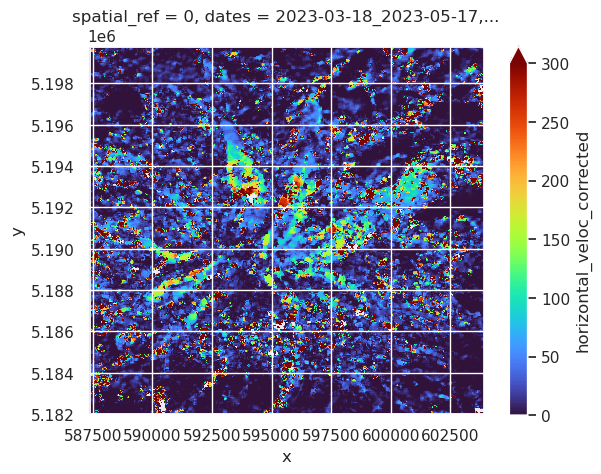

In [89]:
index = 20
print(f'"{early_veloc_ds.isel(dates=index).dates.item()}",')
early_veloc_ds.isel(dates=index)['horizontal_veloc_corrected'].plot.imshow(vmin=0, vmax=300, cmap='turbo')

In [56]:
mask = ~np.isin(veloc_ds['dates'].values, dates_to_remove)
veloc_ds_filtered = veloc_ds.isel(dates=mask)

In [90]:
early_veloc_ds = veloc_ds.where((veloc_ds.start_date.dt.month >= 3) & (veloc_ds.end_date.dt.month < 8), drop=True)

In [91]:
late_veloc_ds = veloc_ds.where((veloc_ds.start_date.dt.month >= 8) & (veloc_ds.end_date.dt.month <= 12), drop=True)

In [57]:
winter_veloc_ds = veloc_ds_filtered.where(((veloc_ds_filtered.start_date.dt.month <= 4) | (veloc_ds_filtered.start_date.dt.month >= 11)) & (veloc_ds_filtered.end_date.dt.month <= 4), drop=True)

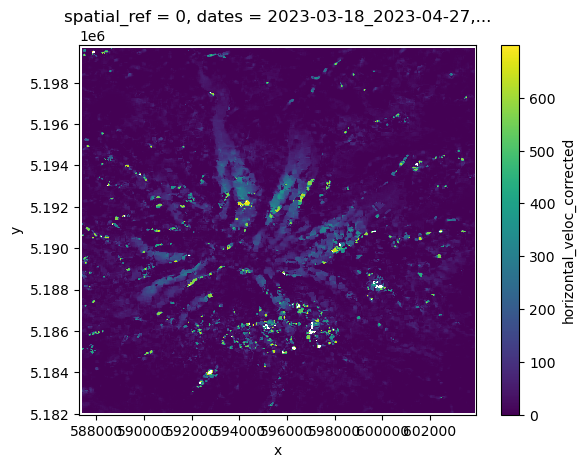

In [74]:
winter_veloc_ds.isel(dates=5).horizontal_veloc_corrected.plot.imshow()

In [58]:
winter_veloc_da_median = winter_veloc_ds.horizontal_veloc_corrected.median(dim='dates')

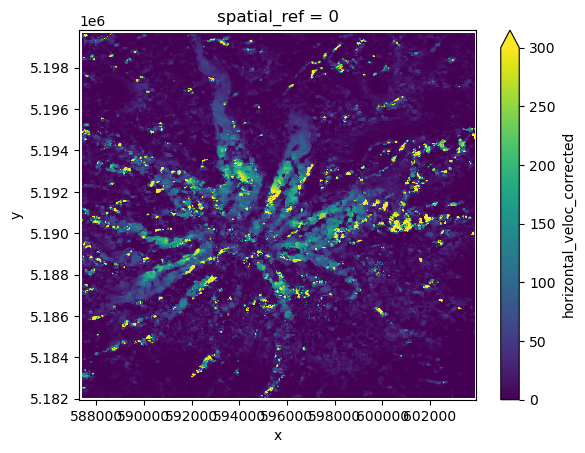

In [59]:
winter_veloc_da_median.plot.imshow(vmax=300)

In [75]:
winter_veloc_da_median.rio.to_raster('median_horizontal_velocity_magnitude_Nov-Apr.tif')

In [92]:
# calculate and save median velocity
early_veloc_da_median = early_veloc_ds.horizontal_veloc_corrected.median(dim='dates')
#veloc_da_median.rio.to_raster('median_horizontal_velocity_magnitude.tif')
# save standard deviation of velocity
early_veloc_da_stdev = early_veloc_ds.horizontal_veloc_corrected.std(dim='dates')
#veloc_da_stdev.rio.to_raster('stdev_horizontal_velocity_magnitude.tif')
# save valid velocity pixel count
early_veloc_da_count = early_veloc_ds.horizontal_veloc_corrected.count(dim='dates')
#veloc_da_count.rio.to_raster('count_horizontal_velocity_magnitude.tif')

/mnt/working/brencher/sw/miniconda3/envs/image-correlation/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [93]:
# calculate and save median velocity
late_veloc_da_median = late_veloc_ds.horizontal_veloc_corrected.median(dim='dates')
#veloc_da_median.rio.to_raster('median_horizontal_velocity_magnitude.tif')
# save standard deviation of velocity
late_veloc_da_stdev = late_veloc_ds.horizontal_veloc_corrected.std(dim='dates')
#veloc_da_stdev.rio.to_raster('stdev_horizontal_velocity_magnitude.tif')
# save valid velocity pixel count
late_veloc_da_count = late_veloc_ds.horizontal_veloc_corrected.count(dim='dates')
#veloc_da_count.rio.to_raster('count_horizontal_velocity_magnitude.tif')

/mnt/working/brencher/sw/miniconda3/envs/image-correlation/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


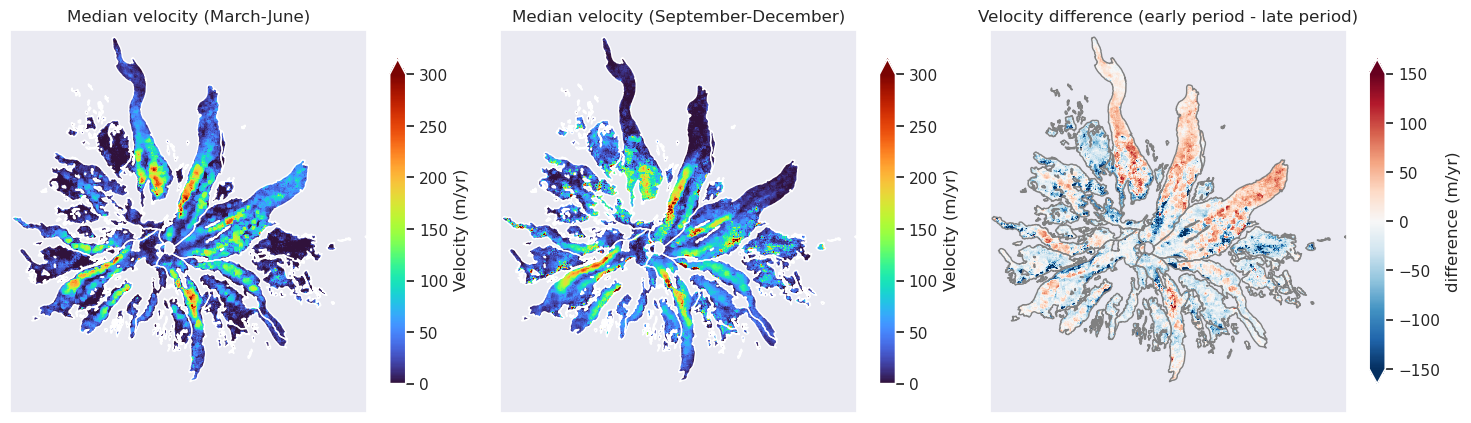

In [41]:
sns.set_theme()
f, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
# early_veloc_da_median.plot(ax=ax[0], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
# late_veloc_da_median.plot(ax=ax[1], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
# (early_veloc_da_median - late_veloc_da_median).plot(ax=ax[2], vmin=-150, vmax=150, cmap='RdBu_r', cbar_kwargs= {'shrink':0.7, 'label':'difference (m/yr)'})
early_veloc_da_median.rio.clip(outlines.geometry).plot(ax=ax[0], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
late_veloc_da_median.rio.clip(outlines.geometry).plot(ax=ax[1], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
(early_veloc_da_median - late_veloc_da_median).rio.clip(outlines.geometry).plot(ax=ax[2], vmin=-150, vmax=150, cmap='RdBu_r', cbar_kwargs= {'shrink':0.7, 'label':'difference (m/yr)'})
outlines.plot(ax=ax[0], facecolor="none", edgecolor="white")
outlines.plot(ax=ax[1], facecolor="none", edgecolor="white")
outlines.plot(ax=ax[2], facecolor="none", edgecolor="gray")
ax[0].set_xlim(veloc_ds.x.min(), veloc_ds.x.max())
ax[0].set_ylim(veloc_ds.y.min(), veloc_ds.y.max())
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[0].set_title(f'Median velocity (March-June)')
ax[1].set_title(f'Median velocity (September-December)')
ax[2].set_title(f'Velocity difference (early period - late period)')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_ylabel('')
f.tight_layout()

f.savefig('../figs/early_late_velocv2_clip.png', dpi=400)

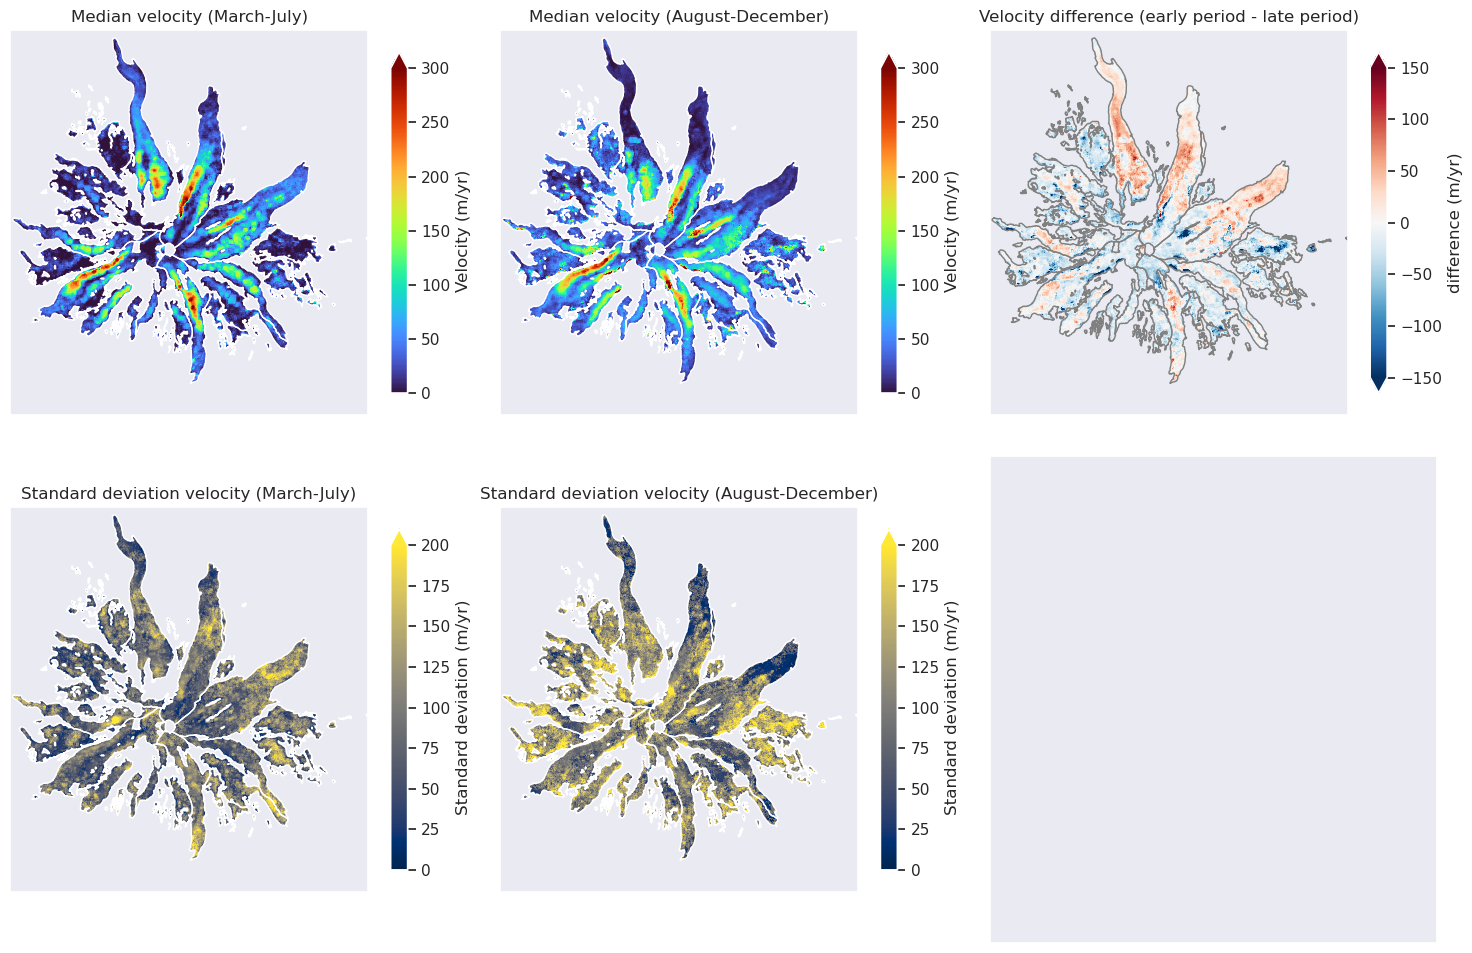

In [95]:
sns.set_theme()
f, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
# early_veloc_da_median.plot(ax=ax[0], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
# late_veloc_da_median.plot(ax=ax[1], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
# (early_veloc_da_median - late_veloc_da_median).plot(ax=ax[2], vmin=-150, vmax=150, cmap='RdBu_r', cbar_kwargs= {'shrink':0.7, 'label':'difference (m/yr)'})
early_veloc_da_median.rio.clip(outlines.geometry).plot(ax=ax[0, 0], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
early_veloc_da_stdev.rio.clip(outlines.geometry).plot(ax=ax[1, 0], vmin=0, vmax=200, cmap='cividis', cbar_kwargs= {'shrink':0.7, 'label':'Standard deviation (m/yr)'})
late_veloc_da_median.rio.clip(outlines.geometry).plot(ax=ax[0, 1], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
late_veloc_da_stdev.rio.clip(outlines.geometry).plot(ax=ax[1, 1], vmin=0, vmax=200, cmap='cividis', cbar_kwargs= {'shrink':0.7, 'label':'Standard deviation (m/yr)'})
(early_veloc_da_median - late_veloc_da_median).rio.clip(outlines.geometry).plot(ax=ax[0, 2], vmin=-150, vmax=150, cmap='RdBu_r', cbar_kwargs= {'shrink':0.7, 'label':'difference (m/yr)'})
outlines.plot(ax=ax[0, 0], facecolor="none", edgecolor="white")
outlines.plot(ax=ax[0, 1], facecolor="none", edgecolor="white")
outlines.plot(ax=ax[1, 0], facecolor="none", edgecolor="white")
outlines.plot(ax=ax[1, 1], facecolor="none", edgecolor="white")
outlines.plot(ax=ax[0, 2], facecolor="none", edgecolor="gray")
ax[0, 0].set_xlim(veloc_ds.x.min(), veloc_ds.x.max())
ax[0, 0].set_ylim(veloc_ds.y.min(), veloc_ds.y.max())
ax[0, 0].set_aspect('equal')
ax[0, 1].set_aspect('equal')
ax[1, 0].set_aspect('equal')
ax[1, 1].set_aspect('equal')
ax[0, 2].set_aspect('equal')
ax[0, 0].set_title(f'Median velocity (March-July)')
ax[0, 1].set_title(f'Median velocity (August-December)')
ax[1, 0].set_title(f'Standard deviation velocity (March-July)')
ax[1, 1].set_title(f'Standard deviation velocity (August-December)')
ax[0, 2].set_title(f'Velocity difference (early period - late period)')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])
ax[0, 0].set_xlabel('')
ax[0, 0].set_ylabel('')
ax[0, 1].set_xlabel('')
ax[0, 1].set_ylabel('')
ax[1, 0].set_xlabel('')
ax[1, 0].set_ylabel('')
ax[1, 1].set_xlabel('')
ax[1, 1].set_ylabel('')
ax[0, 2].set_xlabel('')
ax[0, 2].set_ylabel('')
f.tight_layout()

f.savefig('../figs/early_late_velocv2_wstd_clip.png', dpi=400)

In [285]:
july_da = veloc_ds_filtered.where(veloc_ds_filtered.end_date.dt.month == 7, drop=True).horizontal_veloc_corrected.median(dim='dates')
august_da = veloc_ds_filtered.where((veloc_ds_filtered.start_date.dt.month > 7) & (veloc_ds_filtered.end_date.dt.month == 8), drop=True).horizontal_veloc_corrected.median(dim='dates')
september_da = veloc_ds_filtered.where((veloc_ds_filtered.start_date.dt.month > 8) & (veloc_ds_filtered.end_date.dt.month == 9), drop=True).horizontal_veloc_corrected.median(dim='dates')
october_da = veloc_ds_filtered.where((veloc_ds_filtered.start_date.dt.month > 9) & (veloc_ds_filtered.end_date.dt.month == 10), drop=True).horizontal_veloc_corrected.median(dim='dates')

In [31]:
outlines = gpd.read_file('../mapping/outlines.shp').to_crs(veloc_ds.rio.crs)

In [ ]:
(early_veloc_da_median - late_veloc_da_median).rio.clip(outlines.geometry)

In [315]:
for row in outlines[outlines.area > 2000000].iterrows():
    try:
        diff = (early_veloc_da_median - late_veloc_da_median).rio.clip([row[1].geometry])
        print(row[1].GLACNAME)
    except:
        pass
    

Winthrop Glacier
Ingraham Glacier
Nisqually Glacier
Cowlitz Glacier
Carbon Glacier
Emmons Glacier
Russell Glacier
North Mowich Glacier
South Mowich Glacier
Fryingpan Glacier
Tahoma Glacier
Puyallup Glacier


In [320]:
results = []
for idx, row in outlines[outlines.area > 2000000].iterrows():
    try:
        clipped = (early_veloc_da_median - late_veloc_da_median).rio.clip([row.geometry])

        # Mask out NaNs
        data = clipped.values
        valid_data = data[~np.isnan(data)]

        # Skip if there's no valid data
        if valid_data.size == 0:
            continue

        # Compute statistics
        stats = {
            'GLACNAME': row.GLACNAME,
            'mean': np.mean(valid_data),
            'median': np.median(valid_data),
            'std': np.std(valid_data),
            'min': np.min(valid_data),
            'max': np.max(valid_data)
        }

        results.append(stats)
    
    except Exception as e:
        # Optional: log the error or glacier name if desired
        pass

# Convert results to a DataFrame
stats_df = pd.DataFrame(results)

In [321]:
stats_df

GLACNAME       mean     median        std         min  \
0       Winthrop Glacier   1.843490   0.723441  43.042539 -556.994385   
1       Ingraham Glacier -10.887395  -6.542476  50.951207 -485.674439   
2      Nisqually Glacier   1.999923   0.514366  35.598899 -260.035318   
3        Cowlitz Glacier   7.652908  -0.967508  46.510214 -219.762433   
4         Carbon Glacier   1.773508   1.143510  45.582467 -452.282410   
5         Emmons Glacier -10.511710  -4.577577  39.507693 -464.897962   
6        Russell Glacier   2.631416   1.668991  43.695952 -276.674044   
7   North Mowich Glacier -10.549930  -1.973909  49.552039 -511.355342   
8   South Mowich Glacier  -7.121941  -0.388013  56.995222 -563.163703   
9      Fryingpan Glacier   5.674661   6.427031  47.680615 -509.844590   
10        Tahoma Glacier   8.523945  11.093694  55.254810 -600.882796   
11      Puyallup Glacier   1.909948   3.760005  32.463453 -556.598744   

           max  
0   332.929226  
1   309.123681  
2   404.592399  
3   357.904313  
4   299.377402  
5   424.036407  
6   294.268031  
7   151.869799  
8   153.710735  
9   244.241766  
10  131.020324  
11  145.079745

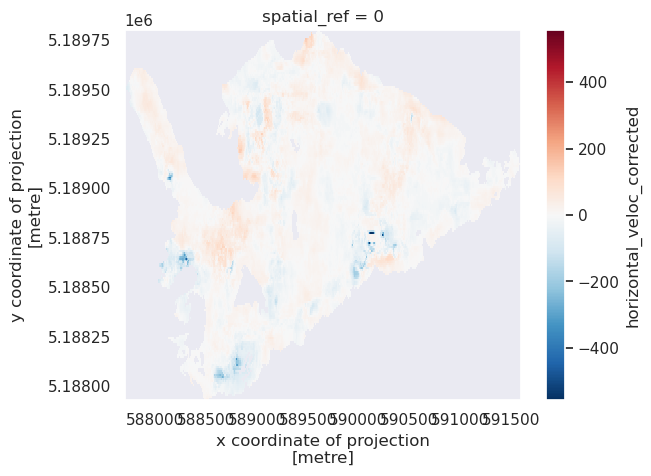

In [317]:
diff.plot()

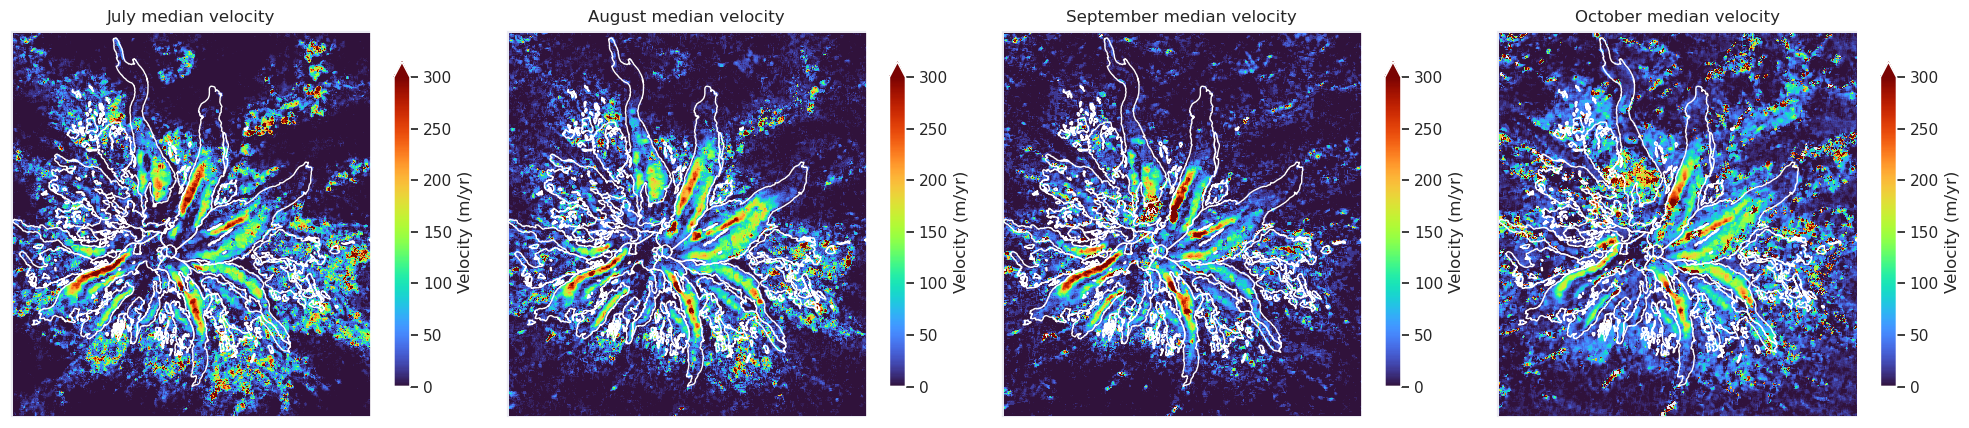

In [286]:
f, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
july_da.plot.imshow(ax=ax[0], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
outlines.to_crs(veloc_ds.rio.crs).plot(ax=ax[0], facecolor="none", edgecolor="white")
august_da.plot.imshow(ax=ax[1], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
outlines.to_crs(veloc_ds.rio.crs).plot(ax=ax[1], facecolor="none", edgecolor="white")
september_da.plot.imshow(ax=ax[2], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
outlines.to_crs(veloc_ds.rio.crs).plot(ax=ax[2], facecolor="none", edgecolor="white")
october_da.plot.imshow(ax=ax[3], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
outlines.to_crs(veloc_ds.rio.crs).plot(ax=ax[3], facecolor="none", edgecolor="white")
ax[0].set_xlim(veloc_ds.x.min(), veloc_ds.x.max())
ax[0].set_ylim(veloc_ds.y.min(), veloc_ds.y.max())
ax[0].set_title(f'July median velocity')
ax[1].set_title(f'August median velocity')
ax[2].set_title(f'September median velocity')
ax[3].set_title(f'October median velocity')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[3].set_aspect('equal')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[3].set_xlabel('')
ax[3].set_ylabel('')
f.tight_layout()

In [42]:
# calculate and save median velocity
veloc_da_median = veloc_ds.horizontal_veloc_corrected.median(dim='dates')
#veloc_da_median.rio.to_raster('median_horizontal_velocity_magnitude.tif')
# save standard deviation of velocity
veloc_da_stdev = veloc_ds.horizontal_veloc_corrected.std(dim='dates')
#veloc_da_stdev.rio.to_raster('stdev_horizontal_velocity_magnitude.tif')
# save valid velocity pixel count
veloc_da_count = veloc_ds.horizontal_veloc_corrected.count(dim='dates')
#veloc_da_count.rio.to_raster('count_horizontal_velocity_magnitude.tif')

/mnt/working/brencher/sw/miniconda3/envs/image-correlation/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


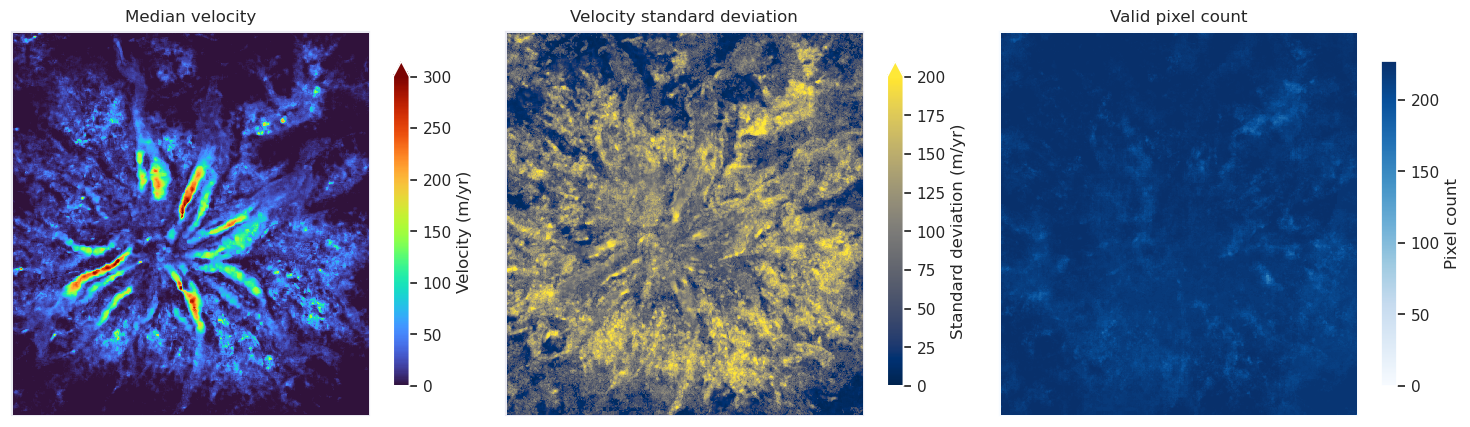

In [43]:
sns.set_theme()
f, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
veloc_da_median.plot(ax=ax[0], vmin=0, vmax=300, cmap='turbo', cbar_kwargs= {'shrink':0.7, 'label':'Velocity (m/yr)'})
veloc_da_stdev.plot(ax=ax[1], vmin=0, vmax=200, cmap='cividis', cbar_kwargs= {'shrink':0.7, 'label':'Standard deviation (m/yr)'})
veloc_da_count.plot(ax=ax[2], vmin=0, cmap='Blues', cbar_kwargs= {'shrink':0.7, 'label':'Pixel count'})
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[0].set_title(f'Median velocity')
ax[1].set_title(f'Velocity standard deviation')
ax[2].set_title(f'Valid pixel count')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_ylabel('')
f.tight_layout()

#f.savefig('../figs/velocity_summary_statistics.png', dpi=400)